# Pancreas 14.5 -> 15.5 OT-ICNN

In [2]:
from moscot.problems.time import TemporalNeuralProblem

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scanpy as sc

import cellrank as cr
import scvelo as scv
import petsc4py
import slepc4py
scv.set_figure_params('scvelo', transparent=True, fontsize=20)

/shared-local/aoq951/miniforge3/envs/neuralot/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


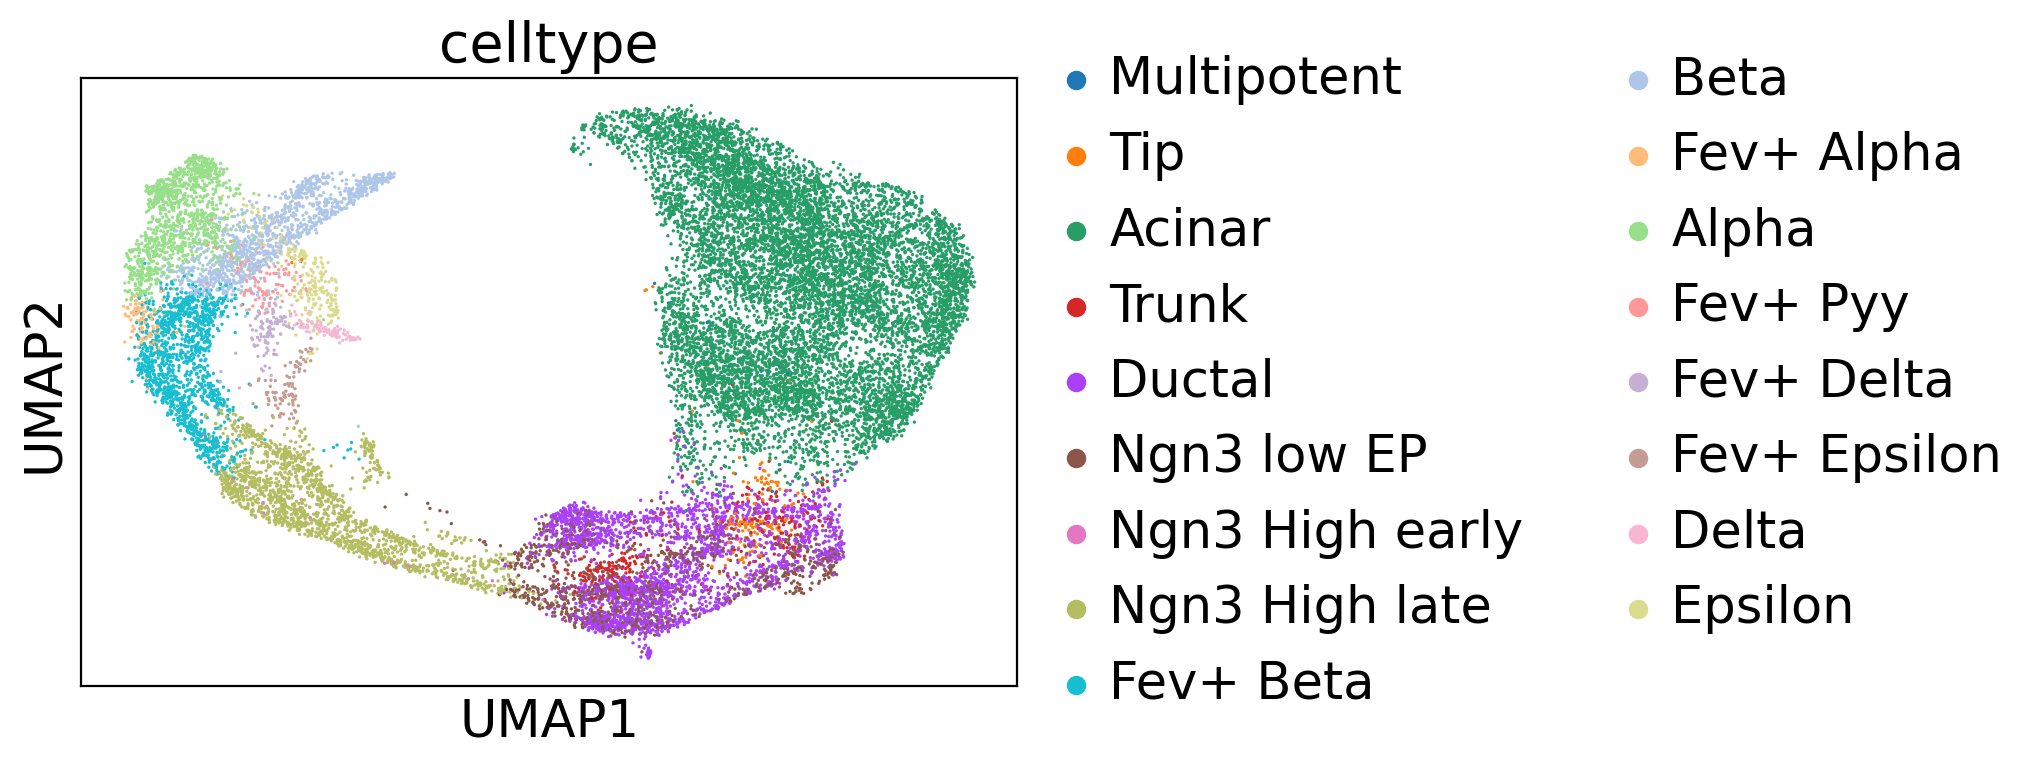

In [3]:
adata = sc.read_h5ad("data/pancreas_1415.h5ad")
sc.pl.umap(adata, color="celltype")

In [4]:
tnp = TemporalNeuralProblem(adata)
tnp = tnp.prepare(time_key="day", joint_attr="X_pca")

In [5]:
tnp = tnp.solve(tau_a=1.0, tau_b=1.0)

INFO     Solving problem BirthDeathNeuralProblem[stage='prepared', shape=(9633, 10886)].                           


  0%|          | 0/25000 [00:00<?, ?it/s]

In [6]:
solution = tnp['14.5','15.5'].solution
solution

NeuralDualOutput[predicted_cost=245.887, best_loss=Array(84.68993, dtype=float32), sinkhorn_dist=239.59451293945312]

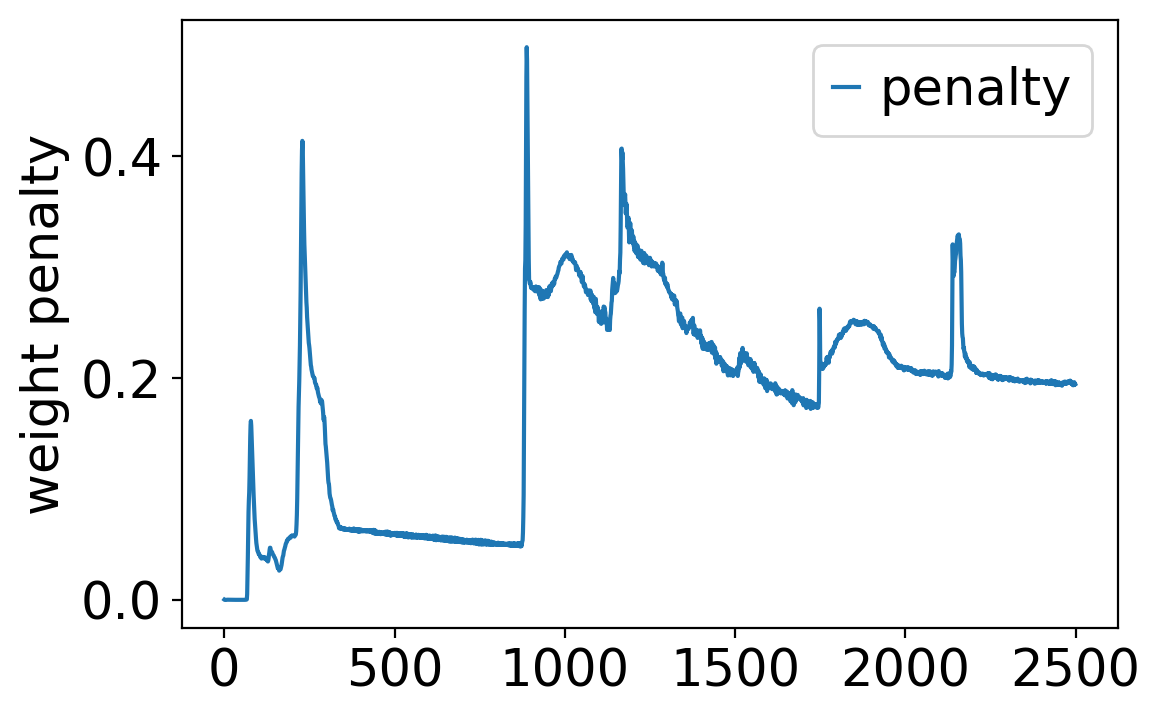

In [8]:
fig, ax = plt.subplots()
ax.plot(solution._training_logs["train_logs"]["penalty"], label="penalty")
ax.set_ylabel("weight penalty")
ax.legend()
plt.show()

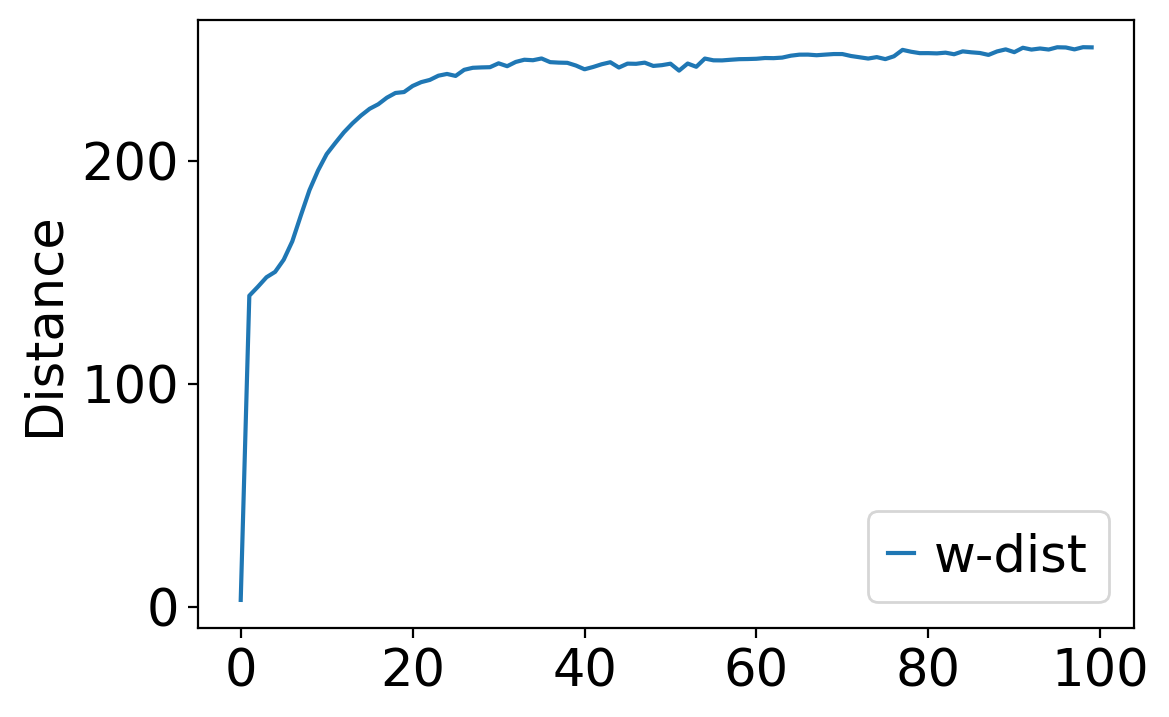

In [9]:
fig, ax = plt.subplots()
ax.plot(solution._training_logs["valid_logs"]["0_1_neural_dual_dist"], label="w-dist")
ax.set_ylabel("Distance")
ax.legend()
plt.show()

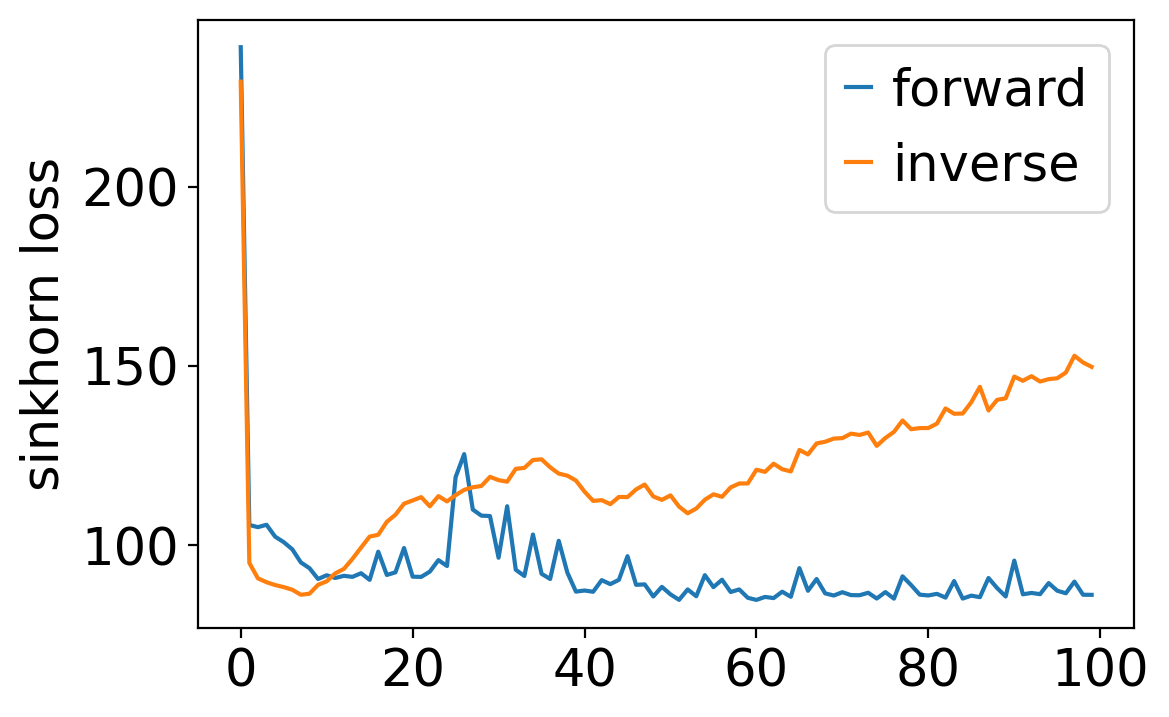

In [10]:
fig, ax = plt.subplots()
ax.plot(solution._training_logs["valid_logs"]["0_1_sinkhorn_loss_forward"], label="forward")
ax.plot(solution._training_logs["valid_logs"]["0_1_sinkhorn_loss_inverse"], label="inverse")
ax.set_ylabel("sinkhorn loss")
ax.legend()
plt.show()

In [11]:
# Prepare for Cellrank
source = jnp.array(adata.obsm["X_pca"].copy())
adata.obs["clusters"] = adata.obs["celltype"]
adata = adata[:, :50].copy()
adata.layers["velocity"] = solution.push(source) - source
adata.layers["velocity"] = np.asarray(adata.layers["velocity"])
adata.layers["pca"] = adata.obsm["X_pca"].copy()

# Velocity Stream Embedding

In [12]:
vk = cr.kernels.VelocityKernel(adata, xkey="pca")
vk.compute_transition_matrix()
adata.uns["velocity_graph"] = vk.transition_matrix

  0%|          | 0/20519 [00:00<?, ?cell/s]

  0%|          | 0/20519 [00:00<?, ?cell/s]

computing velocity embedding
    finished (0:00:03) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


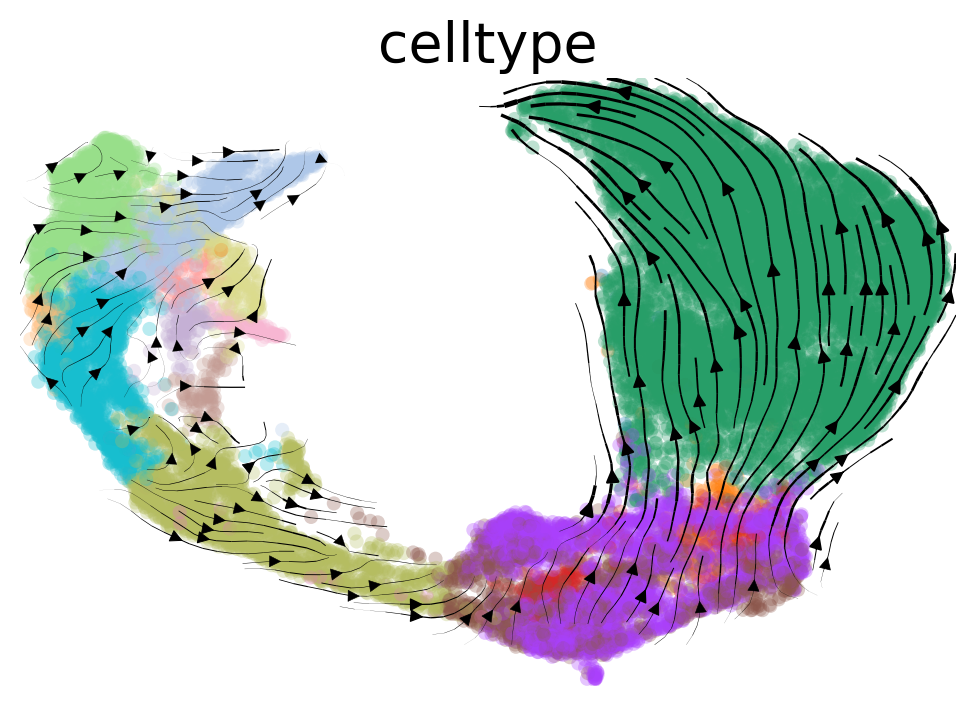

In [13]:
scv.pl.velocity_embedding_stream(adata, basis="umap", color="celltype",smooth=0.5, legend_loc='none')

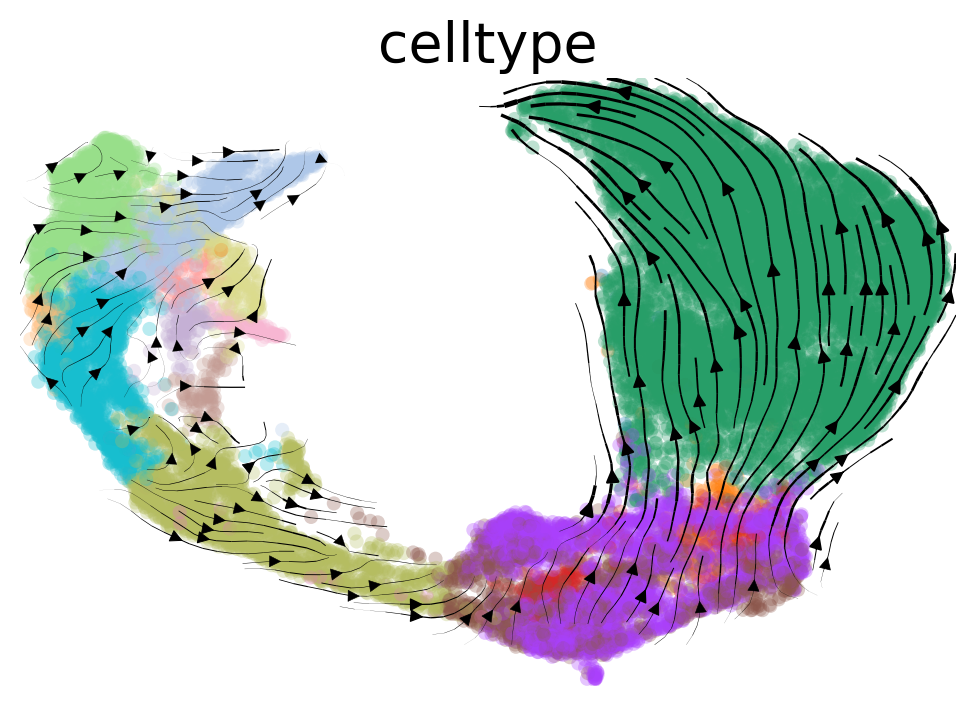

In [14]:
scv.pl.velocity_embedding_stream(adata, basis="umap", color="celltype",smooth=0.5, legend_loc='none')

In [15]:
g = cr.estimators.GPCCA(vk)
g.compute_schur(n_components=20)

GPCCA[kernel=VelocityKernel[n=20519], initial_states=None, terminal_states=None]

# Macro/Terminalstates

In [16]:
g.compute_macrostates(n_states=20, cluster_key="celltype")

GPCCA[kernel=VelocityKernel[n=20519], initial_states=None, terminal_states=None]

/shared-local/aoq951/miniforge3/envs/neuralot/lib/python3.10/site-packages/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/shared-local/aoq951/miniforge3/envs/neuralot/lib/python3.10/site-packages/scvelo/plotting/scatter.py:655: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


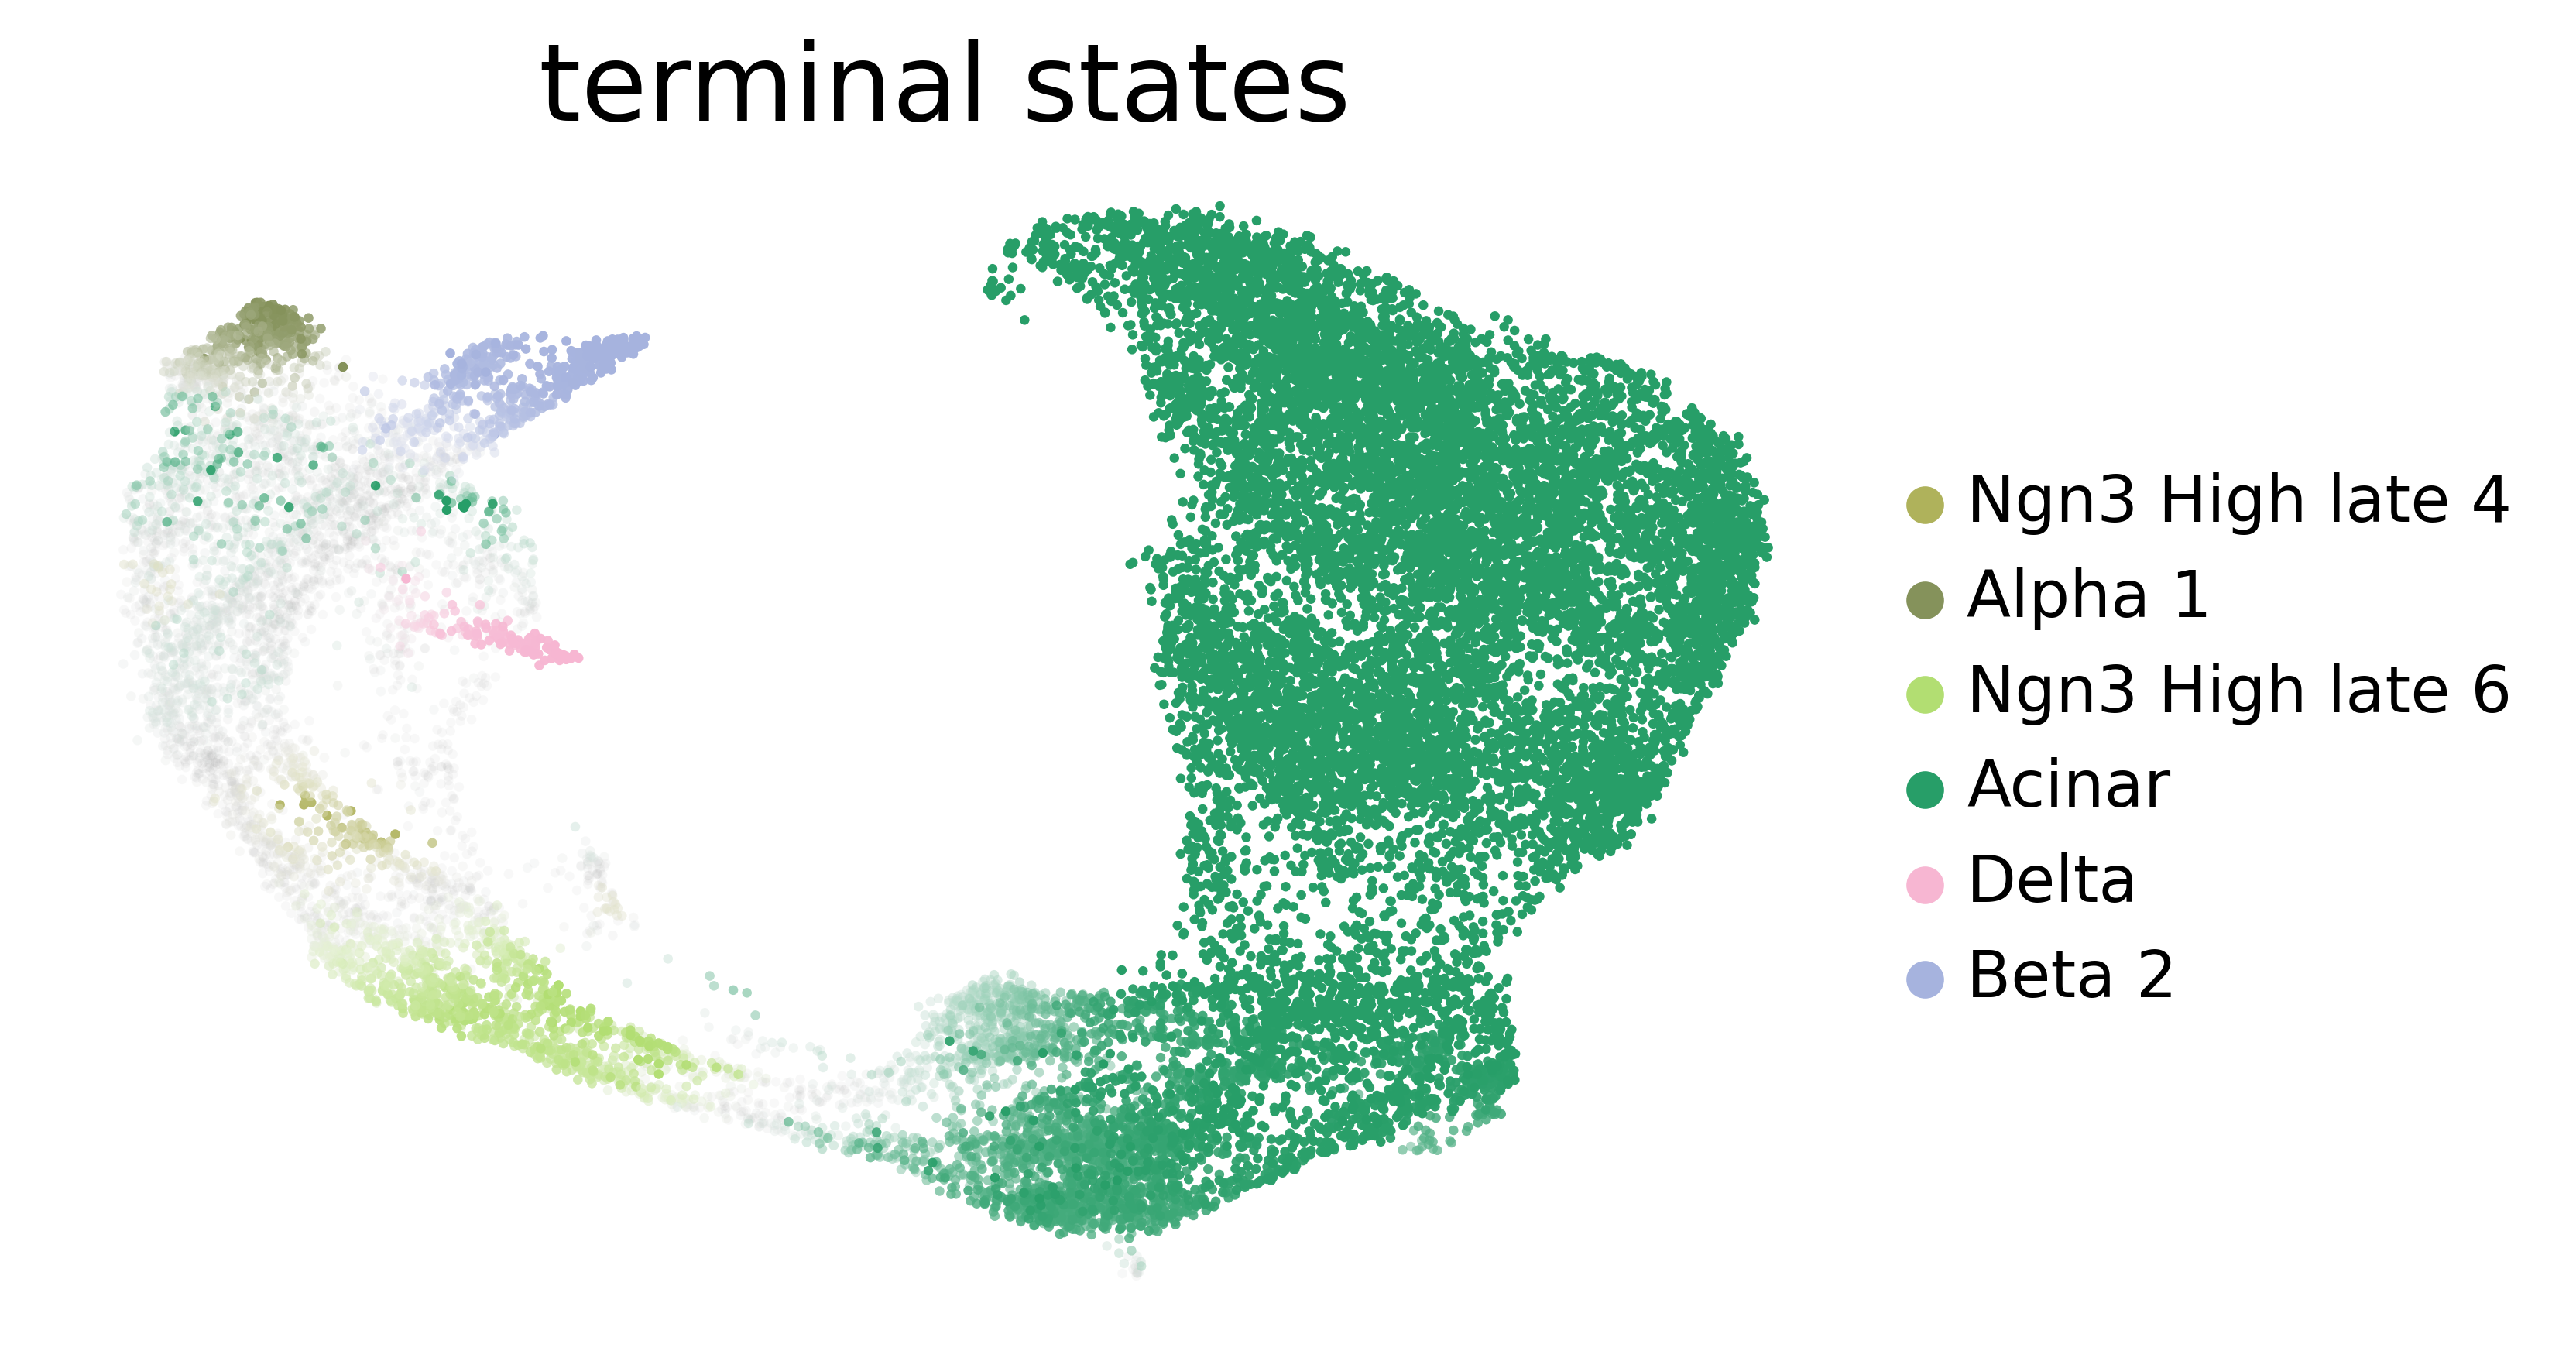

In [17]:
g.predict_terminal_states(method="top_n", n_states=6)
g.plot_macrostates(which="terminal",discrete=False, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

# Fate Probabilities

  0%|          | 0/9 [00:00<?, ?/s]

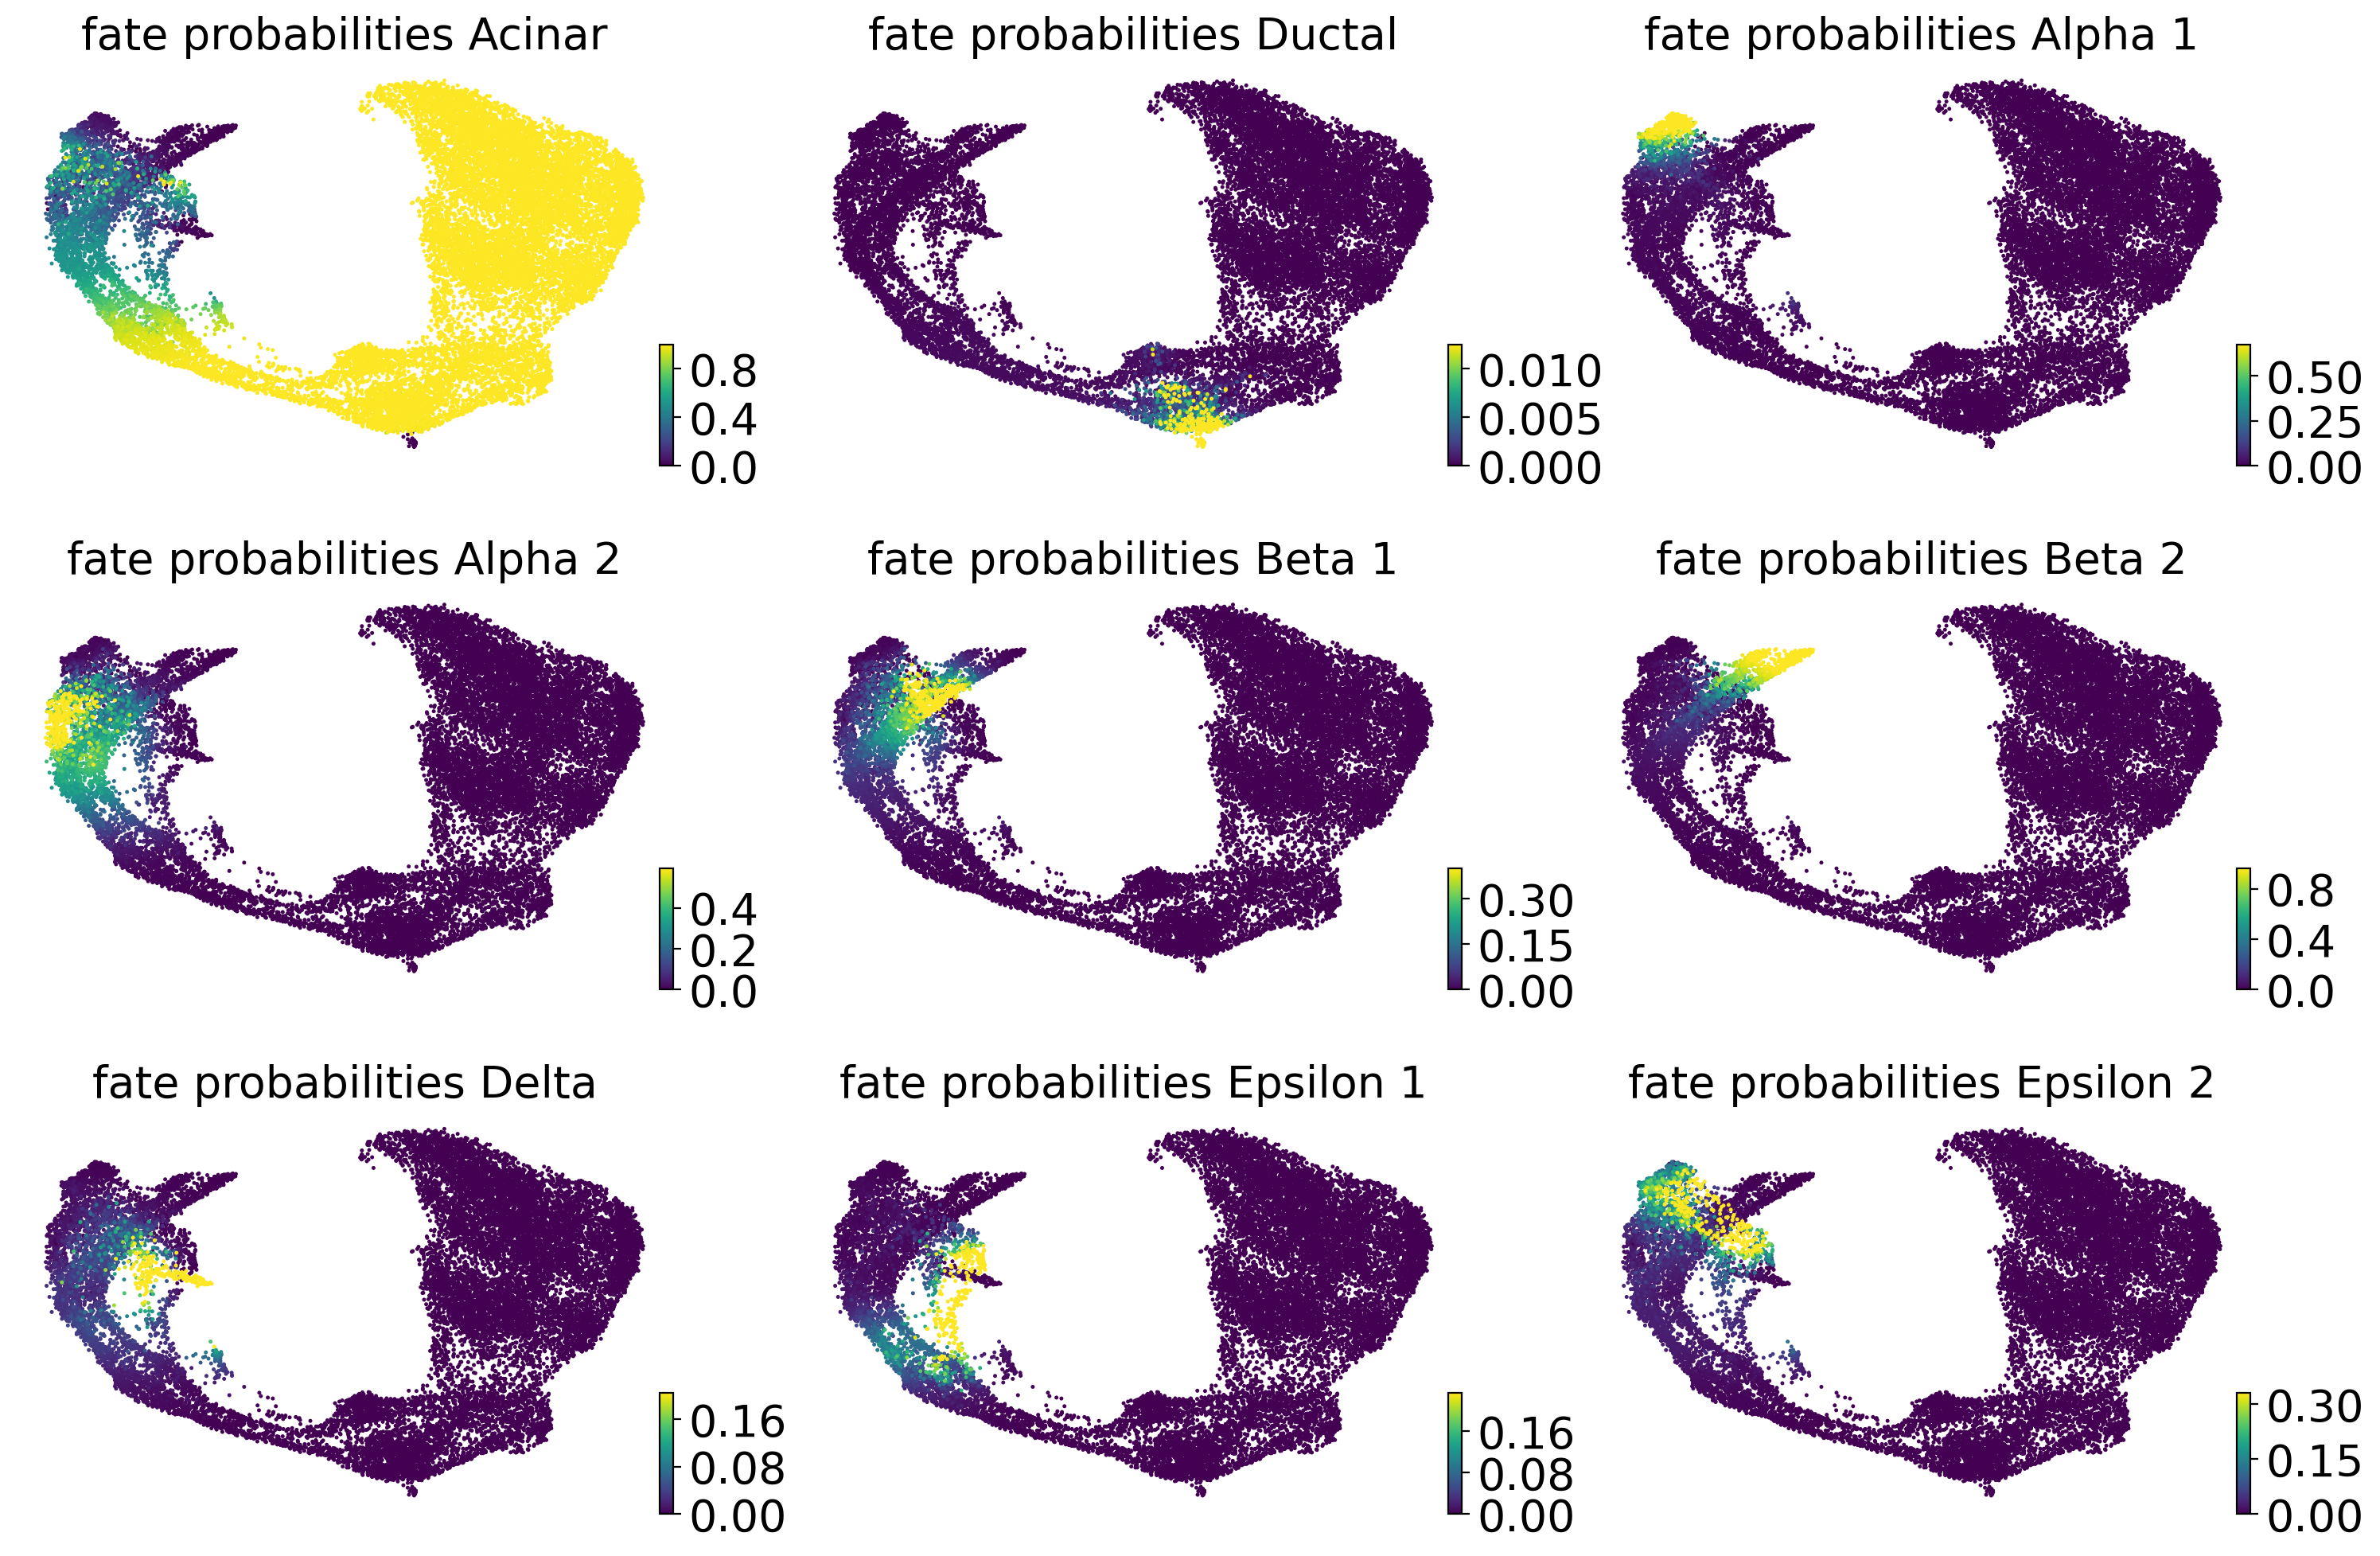

In [18]:
g.set_terminal_states(
    [
        "Acinar", "Ductal", "Alpha_1", "Alpha_2", "Beta_1", "Beta_2", "Delta", "Epsilon_1", "Epsilon_2"
    ]
)
g.compute_fate_probabilities(solver="gmres", use_petsc=True, tol=1e-12, preconditioner='ilu')
g.plot_fate_probabilities(same_plot=False, basis="umap", perc=[0, 99], ncols=3)

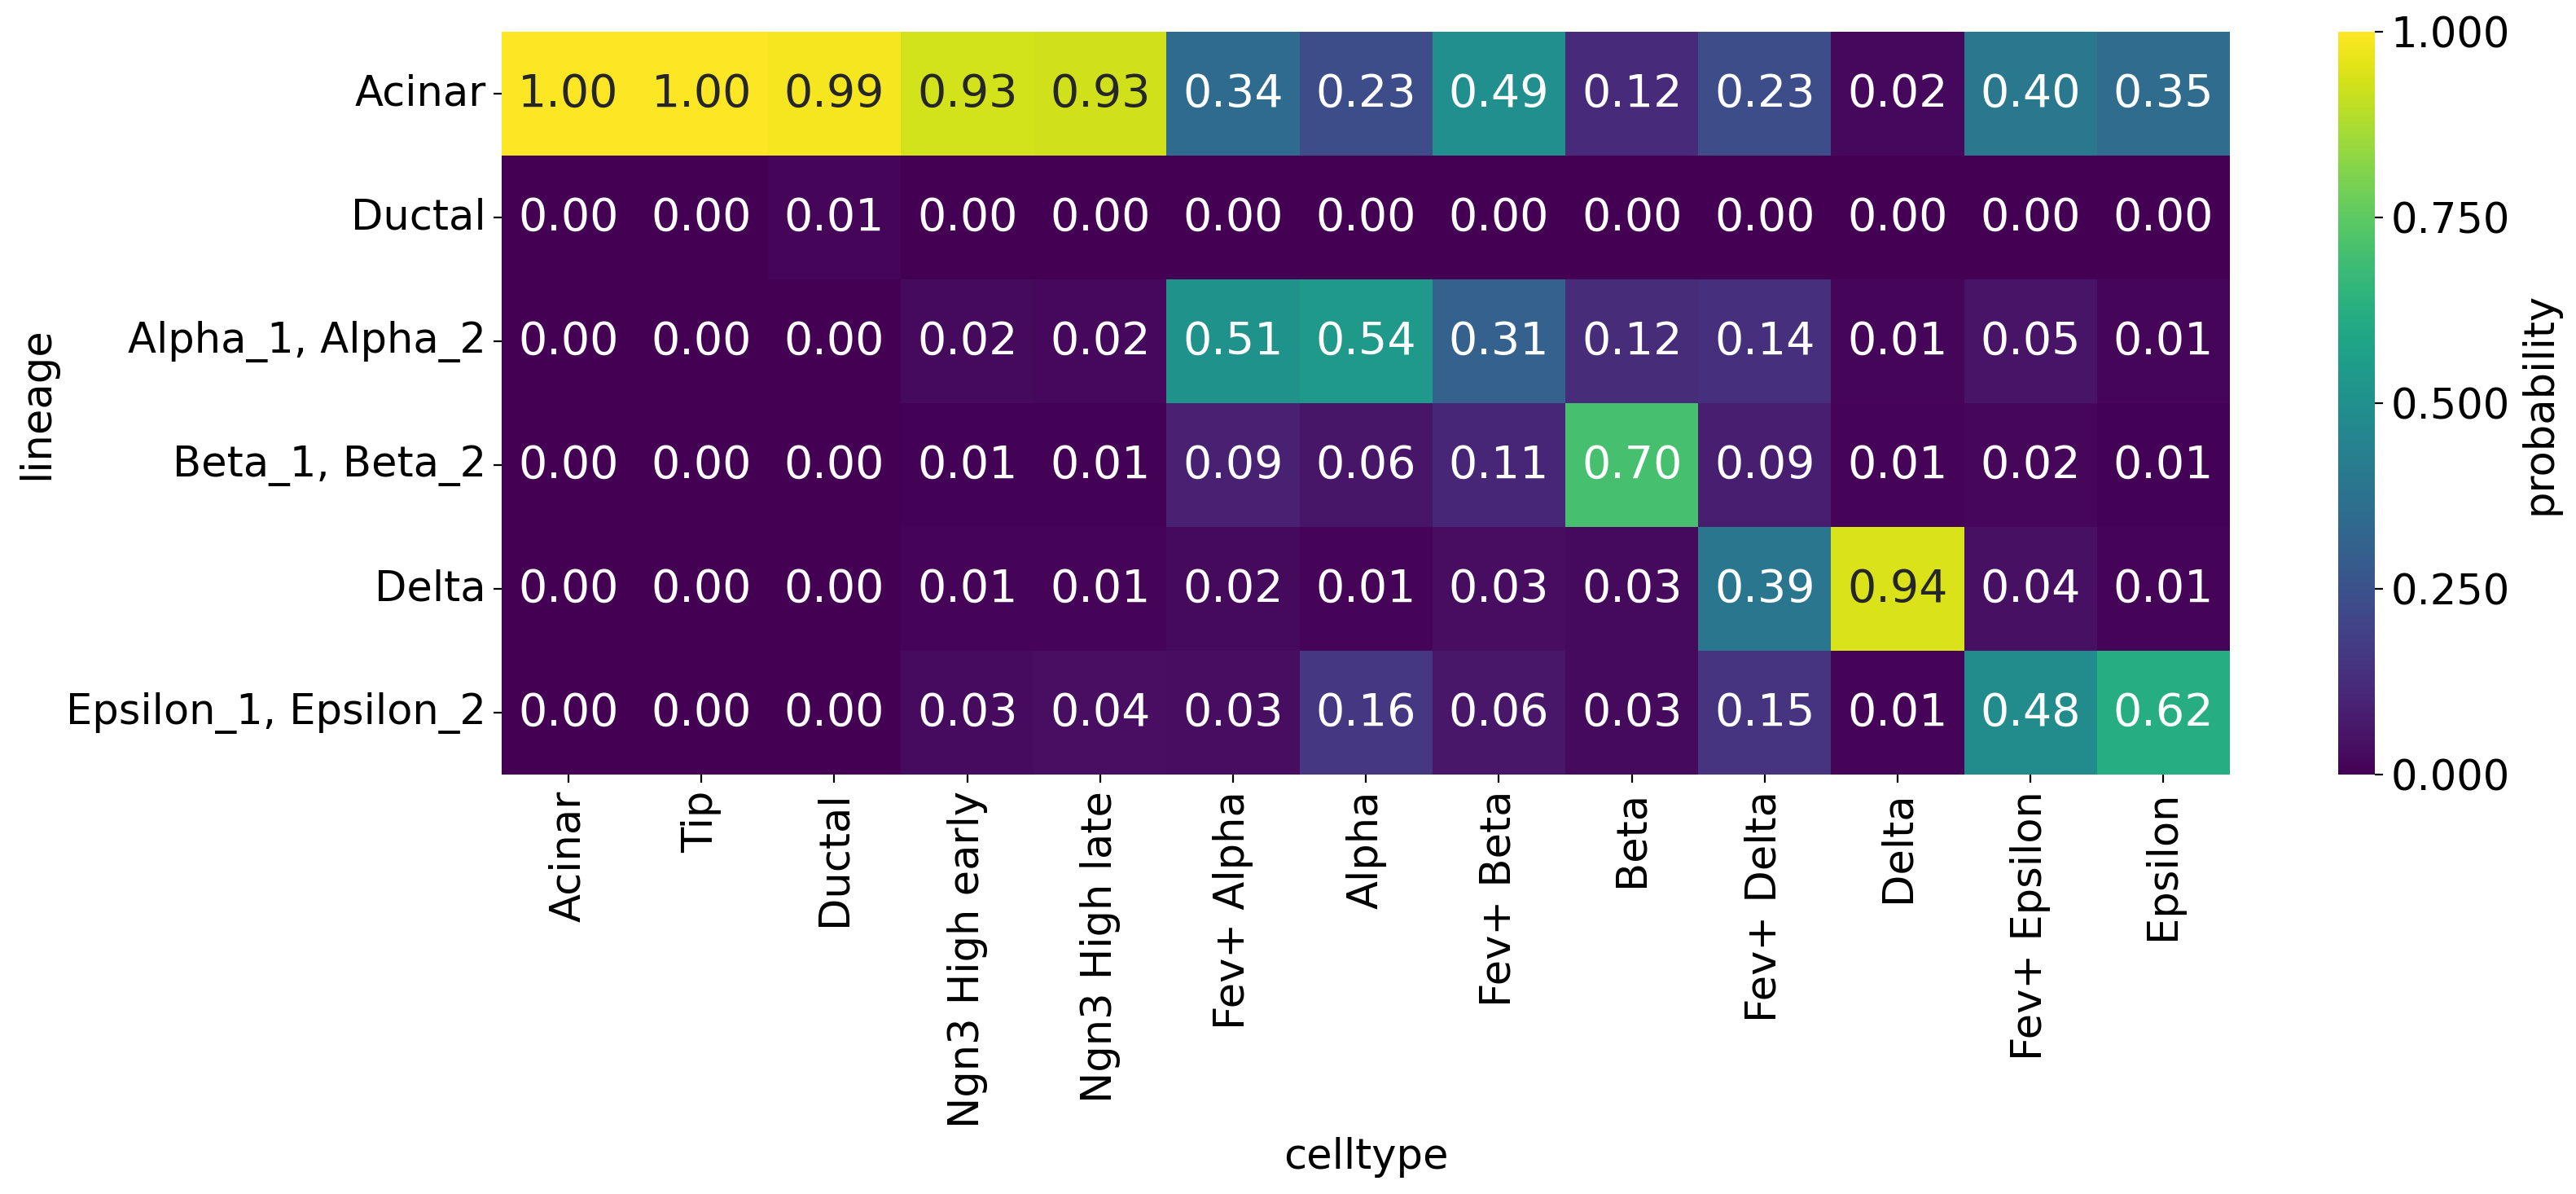

In [19]:
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')

cr.pl.aggregate_fate_probabilities(
    adata,
    mode='heatmap',
    lineages=["Acinar", "Ductal", "Alpha_1, Alpha_2", "Beta_1, Beta_2", "Delta", "Epsilon_1, Epsilon_2"],
    cluster_key='celltype',
    clusters=['Acinar', 'Tip', 'Ductal', 'Ngn3 High early','Ngn3 High late', 'Fev+ Alpha', 'Alpha', 'Fev+ Beta', 'Beta', 'Fev+ Delta', 'Delta', 'Fev+ Epsilon', 'Epsilon'],
    figsize=(17, 6),
    title="",
)

# Aggregated results: EB 0.536 Ngn3 0.07 NEB 0.67